# Bird image classification with NN

Using pytorch.
 
Still a work in progress, even I can classify birds better. So don't grade this yet...
I found another, more challenging project. See part B.

dataset used: https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download

In [1]:
# standard imports
import os

# importing modules
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Setting up device configurations 
# Since I am using a newer mac, for acceleration mps is recommended: 
# https://developer.apple.com/metal/pytorch/
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device


device(type='mps')

In [2]:
# hyperparams
num_epochs = 5
batch_size = 45
learning_rate = 0.001
num_classes = 65

In [3]:
# loading the dataset
train_path = "/Users/timniemeijer/DATA/train_small"
test_path = "/Users/timniemeijer/DATA/test_small"

train_dataset = datasets.ImageFolder(root=train_path, transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(root=test_path, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class BirdClassifier(nn.Module):
    def __init__(self):
        super(BirdClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 56 * 56, num_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = BirdClassifier().to(device)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
total_step = len(train_loader)
loss_values = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')


Epoch [1/5], Step [100/230], Loss: 3.1528
Epoch [1/5], Step [200/230], Loss: 2.6362
Epoch [2/5], Step [100/230], Loss: 1.6942
Epoch [2/5], Step [200/230], Loss: 1.4530
Epoch [3/5], Step [100/230], Loss: 0.4108
Epoch [3/5], Step [200/230], Loss: 0.8384
Epoch [4/5], Step [100/230], Loss: 0.0856
Epoch [4/5], Step [200/230], Loss: 0.7910
Epoch [5/5], Step [100/230], Loss: 0.0297
Epoch [5/5], Step [200/230], Loss: 0.0784


In [7]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')
    

Accuracy on the test set: 60.92%


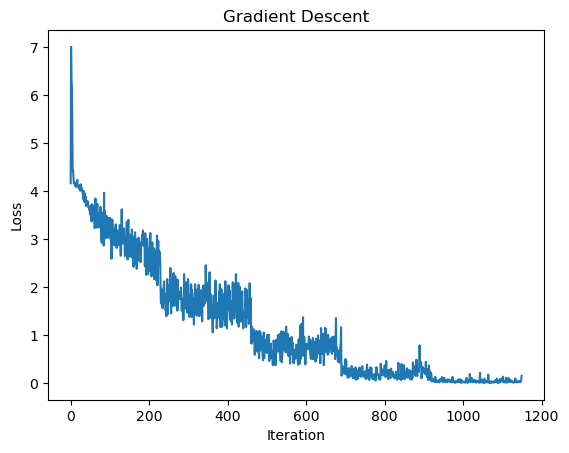

In [8]:
plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Gradient Descent')
plt.show()

In [9]:
folder_names = [bird for bird in os.listdir(test_path) if bird != ".DS_Store"]

folder_names = sorted(folder_names)
bird_dict = {num:bird for num, bird in enumerate(folder_names)}

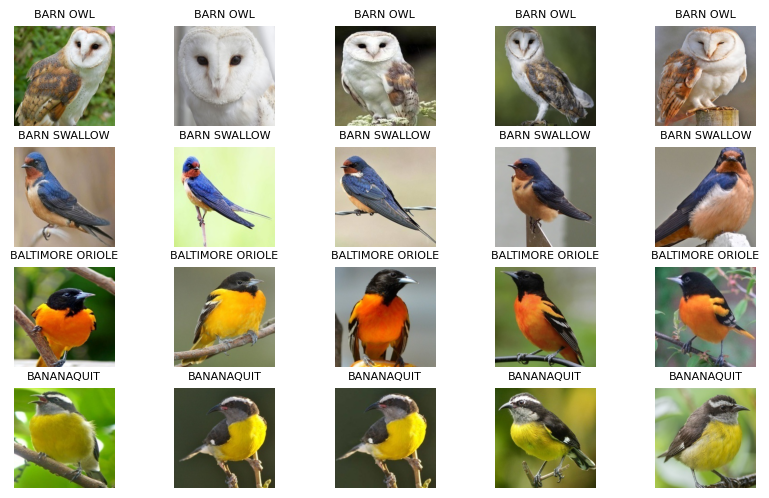

In [10]:


# Plotting the real classes
fig, axes = plt.subplots(4,5,figsize=(10,6))
for images, labels in test_loader:
    for image, label, ax in zip(images, labels, axes.flat):
        ax.imshow(image.permute(1,2,0))
        ax.set_title(bird_dict[int(label)], size=8)
        ax.axis('off')
plt.show()


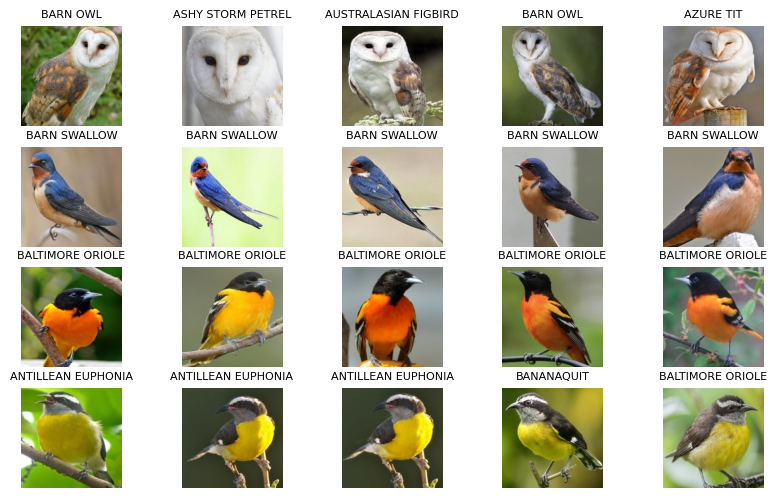

In [11]:
# Plotting the predictions
fig, axes = plt.subplots(4,5,figsize=(10,6))
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    for image, pred, ax in zip(images, predicted, axes.flat):
        pred = int(pred.cpu())
        ax.imshow(image.cpu().permute(1,2,0))
        ax.set_title(bird_dict[pred], size=8)
        ax.axis('off')